# Loading images from the Quick Draw Dataset 5k examples


get the data at https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap?pli=1


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
import keras.backend as K

import tensorflow as tf

import os
import pickle
import numpy as np

Using TensorFlow backend.


In [2]:
print(keras.__version__)
print(tf.__version__)

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2.0.8
1.3.0


[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1333381019897106806, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 639483904
 locality {
   bus_id: 1
 }
 incarnation: 9820858756428368746
 physical_device_desc: "device: 0, name: GeForce GT 640, pci bus id: 0000:01:00.0"]

In [3]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [4]:
MODEL_NAME = 'quickdraw-40classes-5000samples.model'

num_examples_per_class = 5000
num_examples_per_class_train = 4500
num_examples_per_class_test = 500

classes = ['airplane','alarm clock','ambulance','angel','ant','anvil','apple','axe',
                  'banana','bandage','barn','baseball bat','baseball','basket',
                  'basketball','bathtub','beach','bear','beard','bed','bee','belt',
                  'bicycle','binoculars','birthday cake','blueberry',
                  'book','boomerang','bottlecap','bowtie','bracelet','brain',
                  'bread','broom','bulldozer','bus','bush','butterfly','cactus','cake']

In [5]:
len(classes)

40

## Load the image data from scratch

Only use if you are downloading the raw data and doing it yourself

In [130]:
#This cell is only if you are loading the data from scratch
# get the data 
quickdraws = [np.load("./data/x_data_40_classes_2k.npy".format(qdraw))[:num_examples_per_class] for qdraw in classes]

# Concat the arrays together
x_data = np.concatenate(quickdraws,axis=0)

x_data.shape

(200000, 784)

In [6]:
np.save('x_data_40_classes_5k.npy',x_data)

## Use this cell to load the premade datasets that I made

In [18]:
x_data = np.load("./data/x_data_40_classes_5k.npy")

In [19]:
x_data.shape

(200000, 784)

In [8]:
x_data_train = x_data[:num_examples_per_class_train*40]
print(x_data_train.shape)

x_data_test = x_data[len(x_data_train):num_examples_per_class*40]
print(x_data_test.shape)

x_data = x_data_train

(180000, 784)
(20000, 784)


In [20]:
x_img_train = []
x_img_test = []
for i in range(0, 200000, 5000):
    if len(x_img_train) == 0:
        x_img_train = x_data[i:i+4000]
        x_img_test = x_data[i+4000:i+5000]
    else:
        x_img_train = np.append(x_img_train, x_data[i:i+4000], axis=0)
        x_img_test = np.append(x_img_test, x_data[i+4000:i+5000], axis=0)

print(x_img_train.shape)
print(x_img_test.shape)


(160000, 784)
(40000, 784)


## Lets make some labels for our data

In [21]:
labels = [np.full((4000,), classes.index(qdraw)) for qdraw in classes]
print(labels)
## Concat the arrays together
y_data = np.concatenate(labels,axis=0)
y_label_train = y_data

print((y_label_train))
y_label_train.shape

[array([0, 0, 0, ..., 0, 0, 0]), array([1, 1, 1, ..., 1, 1, 1]), array([2, 2, 2, ..., 2, 2, 2]), array([3, 3, 3, ..., 3, 3, 3]), array([4, 4, 4, ..., 4, 4, 4]), array([5, 5, 5, ..., 5, 5, 5]), array([6, 6, 6, ..., 6, 6, 6]), array([7, 7, 7, ..., 7, 7, 7]), array([8, 8, 8, ..., 8, 8, 8]), array([9, 9, 9, ..., 9, 9, 9]), array([10, 10, 10, ..., 10, 10, 10]), array([11, 11, 11, ..., 11, 11, 11]), array([12, 12, 12, ..., 12, 12, 12]), array([13, 13, 13, ..., 13, 13, 13]), array([14, 14, 14, ..., 14, 14, 14]), array([15, 15, 15, ..., 15, 15, 15]), array([16, 16, 16, ..., 16, 16, 16]), array([17, 17, 17, ..., 17, 17, 17]), array([18, 18, 18, ..., 18, 18, 18]), array([19, 19, 19, ..., 19, 19, 19]), array([20, 20, 20, ..., 20, 20, 20]), array([21, 21, 21, ..., 21, 21, 21]), array([22, 22, 22, ..., 22, 22, 22]), array([23, 23, 23, ..., 23, 23, 23]), array([24, 24, 24, ..., 24, 24, 24]), array([25, 25, 25, ..., 25, 25, 25]), array([26, 26, 26, ..., 26, 26, 26]), array([27, 27, 27, ..., 27, 27, 2

(160000,)

In [22]:
labels_test = [np.full((1000,), classes.index(qdraw)) for qdraw in classes]

## Concat the arrays together
y_label_test = np.concatenate(labels_test,axis=0)

print((y_label_test))
y_label_test.shape

[ 0  0  0 ..., 39 39 39]


(40000,)

## lets look at the Images 

In [23]:
def show_object(obj):
    # Reshape 784 array into 28x28 image
    image = obj.reshape([28,28])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(image, cmap='gray_r')
    plt.show()

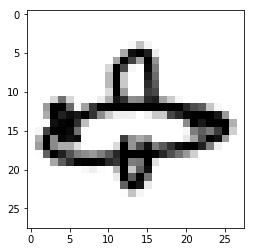

airplane


In [24]:
show_object(x_data[4996])
print(classes[y_data[8]])

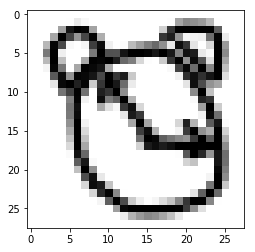

alarm clock


In [25]:
show_object(x_img_train[4000])
print(classes[y_label_train[4000]])

In [26]:
print(x_img_train.shape)
print(y_label_train.shape)

print(x_img_test.shape)
print(y_label_test.shape)

(160000, 784)
(160000,)
(40000, 784)
(40000,)


In [27]:
#shuffling function
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [28]:
print(x_img_train.shape)
print(y_label_train.shape)
x_img_train,y_label_train = unison_shuffled_copies(x_img_train,y_label_train)

(160000, 784)
(160000,)


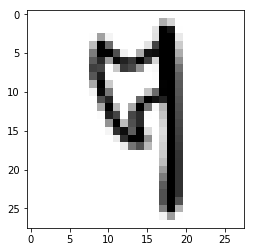

axe


In [29]:
show_object(x_img_train[4000])
print(classes[y_label_train[4000]])

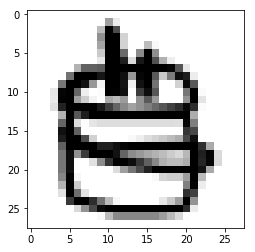

In [30]:
show_object(x_img_train[0])

In [31]:
# Training Parameters for basic MNIST
#learning_rate = 0.1 
training_epochs = 2
batch_size = 100
train_samples = 60000
train_validation = 10000

num_classes = 40

# convert class vectors to binary class matrices
y_label_train = keras.utils.to_categorical(y_label_train, num_classes)
print(y_label_train[0])
print(y_label_train.shape)
y_label_test = keras.utils.to_categorical(y_label_test, num_classes)


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.]
(160000, 40)


In [32]:
img_rows, img_cols = 28, 28

# reshape the data into format (width, Height, channels)
x_img_train = x_img_train.reshape(x_img_train.shape[0], img_rows, img_cols, 1)
x_img_test = x_img_test.reshape(x_img_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [33]:
Inp=Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation='relu',name = 'Conv_01')(Inp)
x = Conv2D(64, (3, 3), activation='relu',name = 'Conv_02')(x)
x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_01')(x)
x = Dropout(0.25,name = 'Dropout_01')(x)
x = Flatten(name = 'Flatten_01')(x)
x = Dense(128, activation='relu',name = 'Dense_01')(x)
#x = BatchNormalization()(x)
x = Dropout(0.5,name = 'Dropout_02')(x)
output = Dense(num_classes, activation='softmax',name = 'Dense_02')(x)

In [34]:
import os

if os.path.exists('{}'.format(MODEL_NAME)):
    model = load_model(MODEL_NAME)
    print("Model loaded.")
else:
    model = Model(Inp,output)
    print("Model created.")

Model loaded.


In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_01 (Conv2D)             (None, 26, 26, 32)        320       
_________________________________________________________________
Conv_02 (Conv2D)             (None, 24, 24, 64)        18496     
_________________________________________________________________
MaxPool_01 (MaxPooling2D)    (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout_01 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
Flatten_01 (Flatten)         (None, 9216)              0         
_________________________________________________________________
Dense_01 (Dense)             (None, 128)               1179776   
__________

In [36]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [49]:
hist = model.fit(x_img_train, y_label_train,
          batch_size=batch_size,
          epochs=training_epochs,
          verbose=1,
          callbacks = None,
          validation_data=(x_img_test, y_label_test))

Train on 160000 samples, validate on 40000 samples
Epoch 1/2
160000/160000 [==============================] - 717s - loss: 1.0686 - acc: 0.6998 - val_loss: 0.8839 - val_acc: 0.7563
Epoch 2/2
160000/160000 [==============================] - 718s - loss: 1.0252 - acc: 0.7106 - val_loss: 0.8714 - val_acc: 0.7622


In [38]:
model.save(MODEL_NAME)

In [39]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    

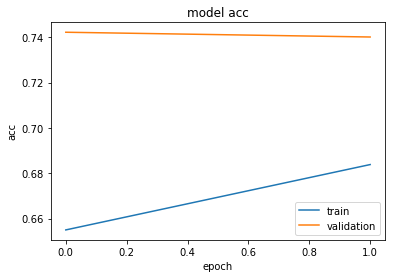

In [40]:
plot_train(hist)

In [45]:
preds = model.predict([x_img_test[:250]])
# print(preds)

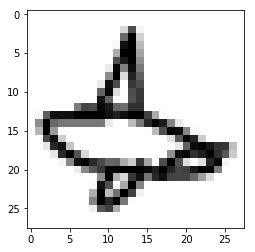

airplane


In [48]:
idx= 200
show_object(x_img_test[idx])
print(classes[np.argmax(preds[idx])])


In [56]:
classes[16]

'beach'

In [58]:
np.argmax(y_train[0])

14